In [1]:
import numpy as np
import random
import types
import qiskit
import qtm.evolution
import random_circuit
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.ecircuit
%load_ext autoreload
%autoreload 2

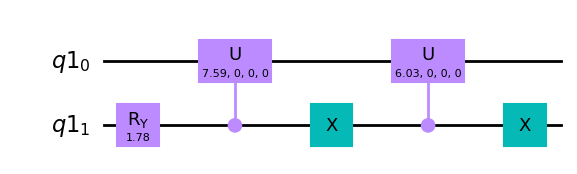

In [4]:
psi = 2*np.random.rand(3**2)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = encoder.qcircuit
qc.draw('mpl')

In [5]:
psi

array([-0.62386008,  0.08064739, -0.61663339, -0.4733475 ])

In [7]:
qc_haar = qtm.state.create_haar_state_inverse(3)
def fitness(qc: qiskit.QuantumCircuit):
    compiler = qtm.qcompilation.QuantumCompilation(
        u = qc,
        vdagger = qc_haar,
        optimizer = 'adam',
        loss_func = 'loss_fubini_study'
    )
    compiler.fit(num_steps = 10, verbose = 0)
    return np.average(compiler.loss_values)

Iter:  0
0.6795748524876963 
0.8255137425262721 
0.7108978915324238 
0.7358442624186949 
0.8873356920002434 
0.9010187247207183 
0.7349411286106152 
0.7878433234142281 
0.7108485624748953 
0.7602200093332863 
0.7494621230277524 
0.8728381526316393 
0.8649984199198151 
0.924832073185069 
0.8014889412331462 
0.6210342294755206 
Iter:  1
0.884632797188998 
0.7674592009317756 
0.8404098213034532 
0.4965302765844877 
0.7456855874694436 
0.780963598431159 
0.8791072112464609 
0.6551611408383811 
0.7850397610143931 
0.836862144000148 
0.6583935588536105 
0.8957812546367325 
0.780964879208945 
0.903180488988899 
0.9444458641885815 
0.7474530793601224 
Iter:  2
0.8513850181886463 
0.8315156725109538 
0.6395291558806131 
0.7665653529044645 
0.6862314421416379 
0.7009819385037787 
0.9005823897921312 
0.871979463515785 
0.7593365999995985 
0.8910530885085487 
0.7551074955117211 
0.7825208021907405 
0.7105087673602664 
0.8236095628976615 
0.9102761401409051 
0.9663881075684184 
Iter:  3
0.840042715

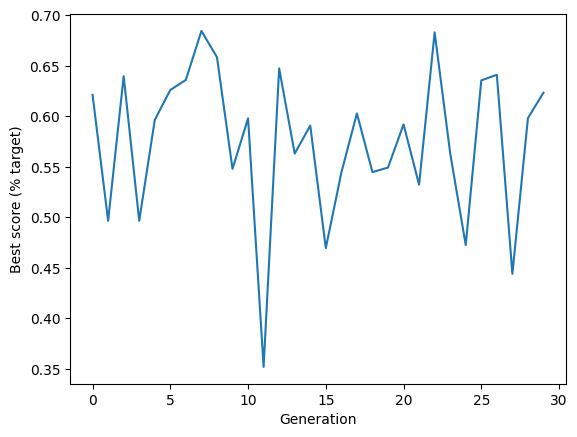

In [80]:
import matplotlib.pyplot as plt
depth = 10
num_individual = 32  # Must mod 8 = 0
maximum_generation = 30
best_score_progress = []  # Tracks progress
num_qubits = 3
threshold = 0.2

population = qtm.ecircuit.create_population(num_individual, num_qubits, depth, fitness)
best_candidate = population[0]
for generation in range(maximum_generation):
    print("Iter: ", generation)
    population = sorted(population, key=lambda obj: obj.fitness)[
        :int(num_individual/2)]
    scores = []
    new_population = []
    for i in range(0, int(num_individual/2), 2):
        parent_1 = population[i]
        parent_2 = population[i+1]
        child_1, child_2 = parent_1.crossover(parent_2)
        child_1.compile()
        child_2.compile()
        new_population.append(child_1)
        scores.append(child_1.fitness)
        new_population.append(child_2)
        scores.append(child_2.fitness)
    for score in scores:
        print(f"{score} ")

    population = new_population
    prob_mutate = 0.01
    for individual in population:
        if random.random() < prob_mutate:
            individual.mutate(qtm.evolution.mutate) 
    # population = qtm.evolution.random_mutate(
    #     population, prob_mutate, qtm.evolution.mutate)

    best_score = np.min(scores)
    best_index = np.argmin(scores)
    if best_candidate.fitness > population[best_index].fitness:
        best_candidate = population[best_index]
    best_score_progress.append(best_score)
    if best_score < threshold:
        break
print(best_candidate.qc)
# GA has completed required generation
print('End best score, percent target: %.1f' % best_score)

# Plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()


In [81]:
qc = best_candidate.qc
compiler = qtm.qcompilation.QuantumCompilation(
    u = qc,
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    vdagger = qc_haar,
    optimizer = 'adam',
    loss_func = 'loss_fubini_study'
)
compiler.set_thetas(your_thetas)
compiler.fit(num_steps = 100, verbose = 1)

Step: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


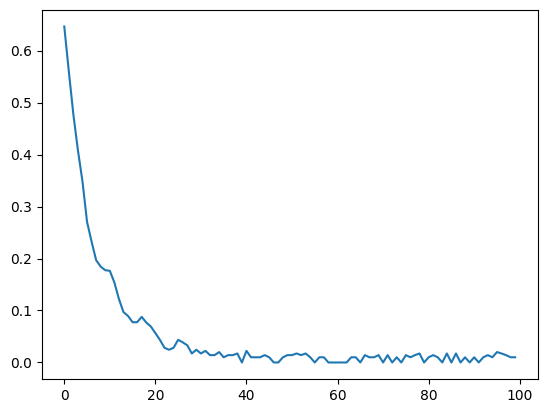

In [83]:
plt.plot(compiler.loss_values)

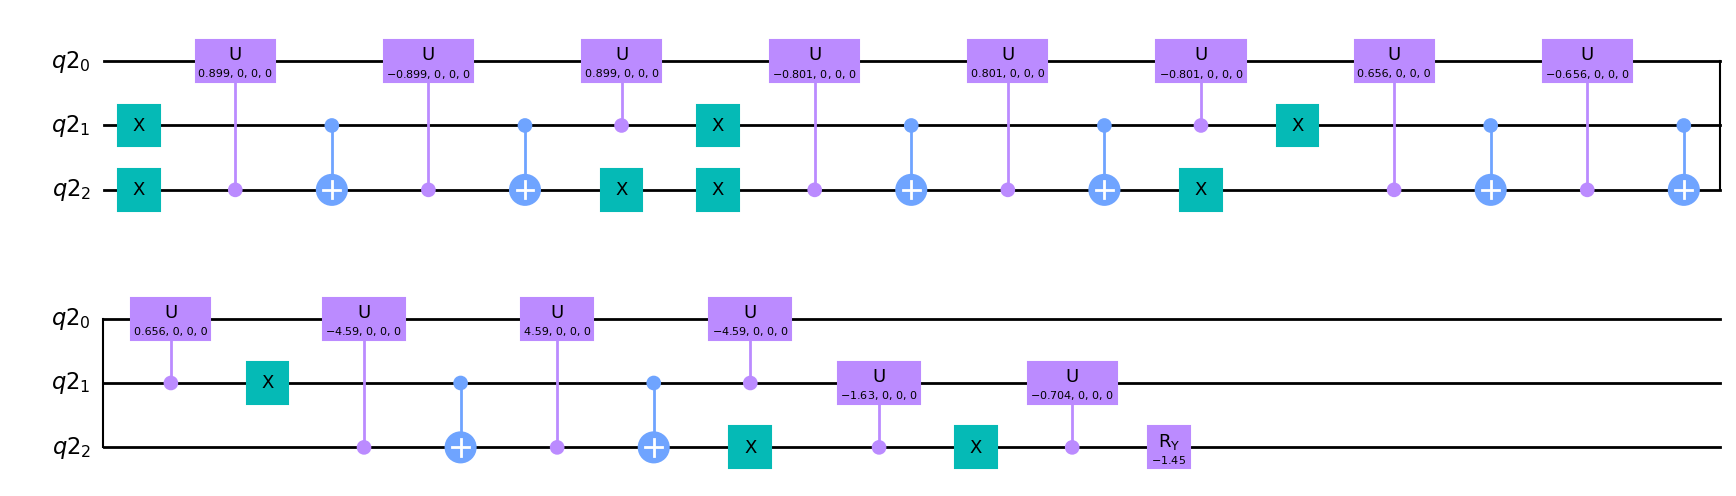

In [8]:
qc_haar.draw('mpl')

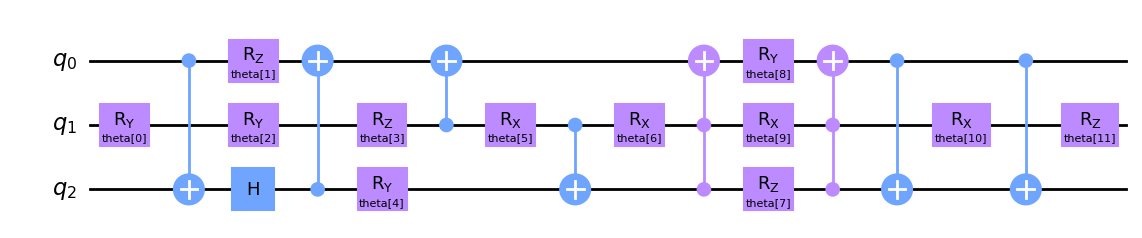

In [84]:
qc.draw('mpl')

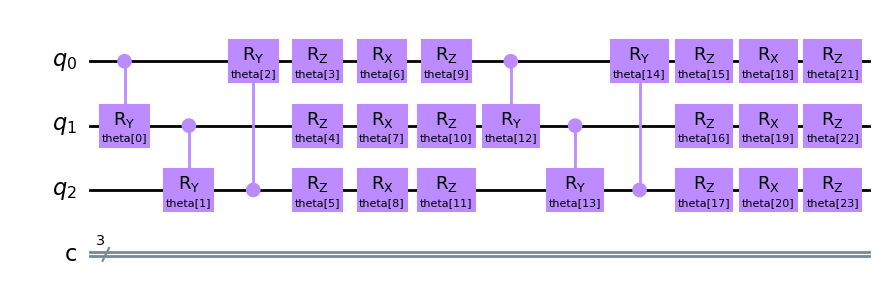

In [85]:
qtm.ansatz.create_Wchain_layered_ansatz(3,2).draw('mpl')

In [64]:
compiler2 = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    u = qtm.ansatz.create_Wchain_layered_ansatz(3,1),
    vdagger = qc_haar,
    optimizer = 'adam',
    loss_func = 'loss_fubini_study'
)
compiler2.fit(num_steps = 100, verbose = 1)

Step: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


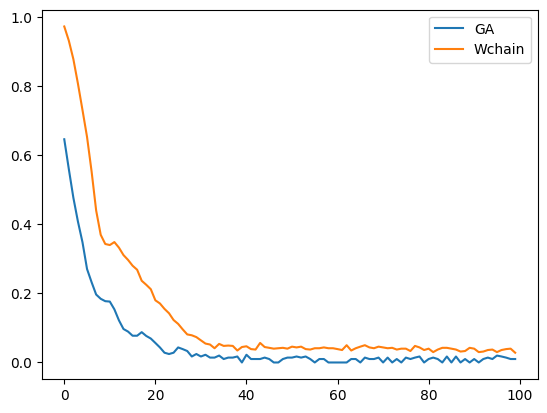

In [88]:
plt.plot(compiler.loss_values, label = 'GA')
plt.plot(compiler2.loss_values, label = 'Wchain')
plt.legend()